In [1]:
# Imports
# !pip install torchinfo
import torch
import torch.nn as nn
import torch.utils.data as Data
from torchvision import datasets, transforms
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time
import Trainer_v03b2 as TP

## Network structures

In [10]:
m1 = TP.ImageEncoder(latent_dim=256)
summary(m1, input_size=(1, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
ImageEncoder                             [4, 512]                  --
├─Sequential: 1-1                        [1, 16, 128, 128]         --
│    └─Conv2d: 2-1                       [1, 16, 128, 128]         160
│    └─Identity: 2-2                     [1, 16, 128, 128]         --
│    └─LeakyReLU: 2-3                    [1, 16, 128, 128]         --
├─Sequential: 1-2                        [1, 32, 64, 64]           --
│    └─Conv2d: 2-4                       [1, 32, 128, 128]         4,640
│    └─Identity: 2-5                     [1, 32, 128, 128]         --
│    └─LeakyReLU: 2-6                    [1, 32, 128, 128]         --
│    └─MaxPool2d: 2-7                    [1, 32, 64, 64]           --
├─Sequential: 1-3                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 64, 64, 64]           18,496
│    └─Identity: 2-9                     [1, 64, 64, 64]           --
│    └─

In [8]:
m2 = TP.ImageDecoder(latent_dim=256)
summary(m2, input_size=(1, 512))

Layer (type:depth-idx)                   Output Shape              Param #
ImageDecoder                             [1, 1, 128, 128]          --
├─Sequential: 1-1                        [1, 256]                  --
│    └─Linear: 2-1                       [1, 4096]                 1,052,672
│    └─ReLU: 2-2                         [1, 4096]                 --
│    └─Linear: 2-3                       [1, 256]                  1,048,832
│    └─ReLU: 2-4                         [1, 256]                  --
├─Sequential: 1-2                        [1, 128, 4, 4]            --
│    └─ConvTranspose2d: 2-5              [1, 128, 4, 4]            524,416
│    └─Identity: 2-6                     [1, 128, 4, 4]            --
│    └─LeakyReLU: 2-7                    [1, 128, 4, 4]            --
├─Sequential: 1-3                        [1, 64, 8, 8]             --
│    └─ConvTranspose2d: 2-8              [1, 64, 8, 8]             131,136
│    └─Identity: 2-9                     [1, 64, 8, 8]       

In [5]:
m3 = TP.CsiEncoder()
summary(m3, input_size=(2, 90, 100))

Layer (type:depth-idx)                   Output Shape              Param #
CsiEncoder                               [1, 256]                  353,374,464
├─Sequential: 1-1                        [1, 16, 30, 98]           --
│    └─Conv2d: 2-1                       [1, 16, 30, 98]           160
│    └─LeakyReLU: 2-2                    [1, 16, 30, 98]           --
├─Sequential: 1-2                        [1, 32, 14, 48]           --
│    └─Conv2d: 2-3                       [1, 32, 14, 48]           4,640
│    └─LeakyReLU: 2-4                    [1, 32, 14, 48]           --
├─Sequential: 1-3                        [1, 64, 12, 46]           --
│    └─Conv2d: 2-5                       [1, 64, 12, 46]           18,496
│    └─LeakyReLU: 2-6                    [1, 64, 12, 46]           --
├─Sequential: 1-4                        [1, 128, 10, 44]          --
│    └─Conv2d: 2-7                       [1, 128, 10, 44]          73,856
│    └─LeakyReLU: 2-8                    [1, 128, 10, 44]       

## Loader

In [2]:
transform = transforms.Compose([transforms.Resize([128,128]),
                                transforms.ToTensor(),
                      #          transforms.Normalize((0.5, ), (0.5, ))
])

data_train = datasets.MNIST(root = "../Dataset/MNIST/",
                            transform=transform,
                            train = True,
                            download = True)

data_test = datasets.MNIST(root="../Dataset/MNIST/",
                           transform = transform,
                           train = False)

train_loader = torch.utils.data.DataLoader(dataset=data_train,
                                           batch_size = 64,
                                           shuffle = True,
                                          drop_last=True)

valid_loader = train_loader

test_loader = torch.utils.data.DataLoader(dataset=data_test,
                                          batch_size = 64,
                                          drop_last=True,
                                          shuffle = True)

In [3]:
# Hyperparameters
t_args = TP.MyArgs(cuda=1, epochs=10, learning_rate=1e-5, criterion=nn.SmoothL1Loss(reduction="sum"))
s_args = TP.MyArgs(cuda=1, epochs=100, learning_rate=1e-5, criterion=nn.SmoothL1Loss())

In [4]:
# Model and Loss
imgencoder = TP.ImageEncoder(batchnorm=False, latent_dim=8).to(t_args.device)
imgdecoder = TP.ImageDecoder(batchnorm=False, latent_dim=8, active_func=nn.LeakyReLU()).to(t_args.device)
csiencoder = TP.CsiEncoder(batchnorm=False, latent_dim=256).to(t_args.device)
optimizer = torch.optim.Adam

trainer = TP.TrainerVariationalTS(img_encoder=imgencoder, img_decoder=imgdecoder, csi_encoder=csiencoder,
                                   teacher_args=t_args, student_args=s_args, 
                                   train_loader=train_loader, valid_loader=valid_loader, test_loader=test_loader,
                                   optimizer=optimizer, temperature=1, latent_dim=8,kl_weight=0.25)

In [ ]:
# Load from checkpoints
trainer.toal_epochs=0
imgencoder.load_state_dict(torch.load('../Models/ImgEn_Model_v02a1_ImgEn_Fc_0307_tep1200.pth'))
imgdecoder.load_state_dict(torch.load('../Models/ImgDe_Model_v02a1_ImgDe_FC_0307_tep1200.pth'))
csiencoder.load_state_dict(torch.load('../Models/CSIEn_Model_v02a1_CsiEn_Last_0307_tep1200_sep700.pth'))

In [50]:
# When changing learning rate
t_args = TP.MyArgs(cuda=1, epochs=100, learning_rate=1e-6, criterion=nn.SmoothL1Loss(reduction="sum"))
s_args = TP.MyArgs(cuda=1, epochs=100, learning_rate=1e-7, criterion=nn.SmoothL1Loss())
trainer.teacher_args = t_args
trainer.student_args = s_args

In [51]:
# Training and Saving
trainer.train_teacher() 

Teacher: epoch=99/100,936/937of train, loss=248.75253295898438
Total training time: 4603.890536785126 sec


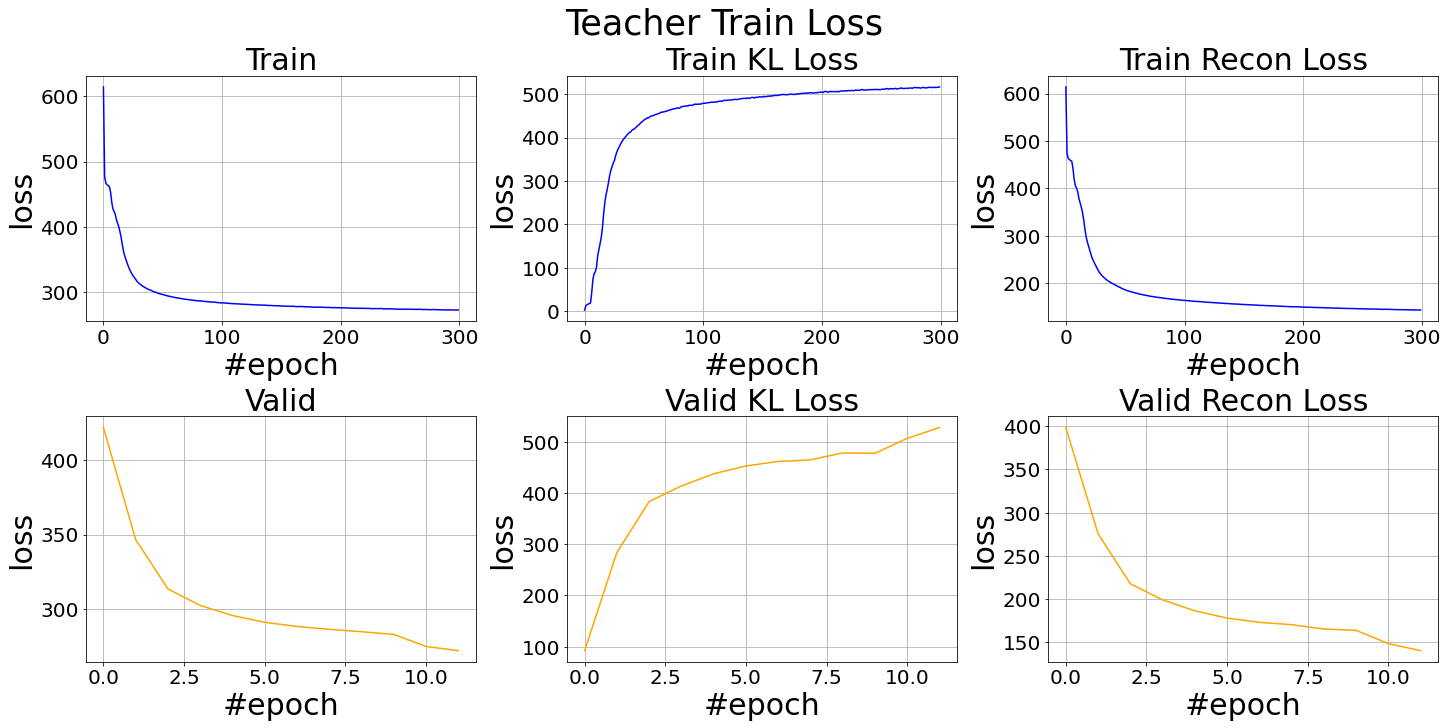

In [52]:
# Plot loss curves
%matplotlib inline
trainer.plot_teacher_loss()

In [53]:
  #=====================test============================
trainer.test_teacher(mode='train')

Teacher: 930/937of test, loss=4.8538193702697758

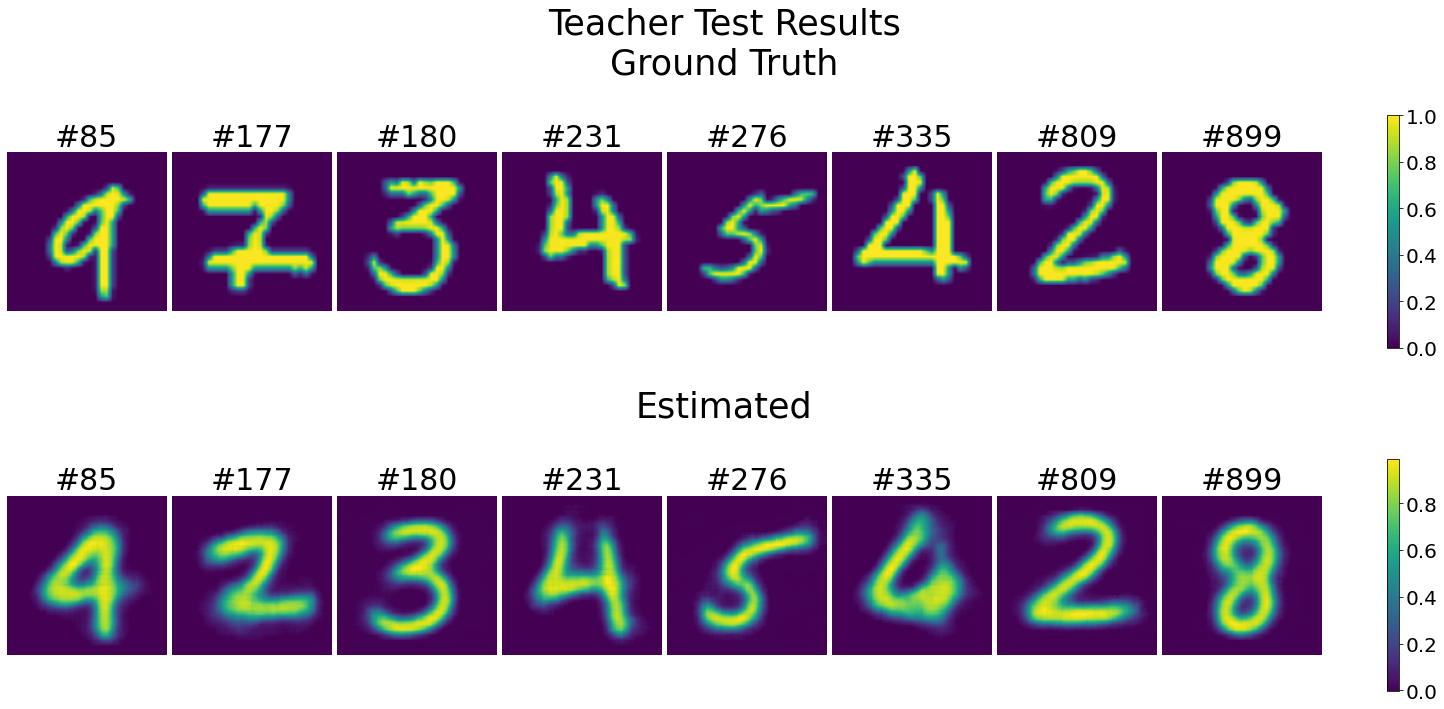

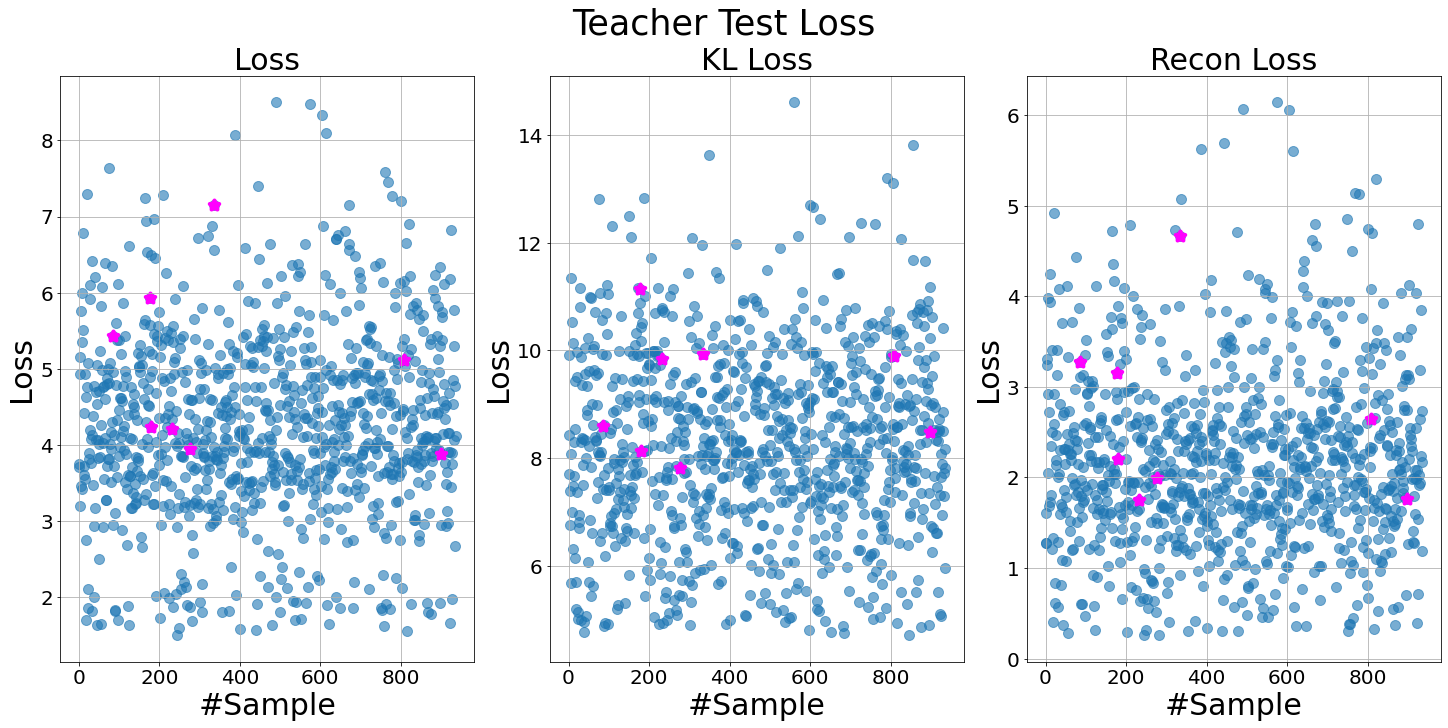

In [54]:
%matplotlib inline
trainer.plot_teacher_test(select_num=8)

In [ ]:
# Training and Saving
trainer.train_student()

In [ ]:
# Plot loss curves
%matplotlib inline
trainer.plot_student_loss()

In [ ]:
  #=====================test============================
trainer.test_student()

In [ ]:
# Final outputs
%matplotlib inline
trainer.plot_student_test()

In [33]:
notion = '_0307'
torch.save(trainer.csi_encoder.state_dict(),
           '../Models/CSIEn_' + str(trainer.csi_encoder) + notion + '_tep' + str(trainer.teacher_epochs) +
           '_sep' + str(trainer.student_epochs) + '.pth')

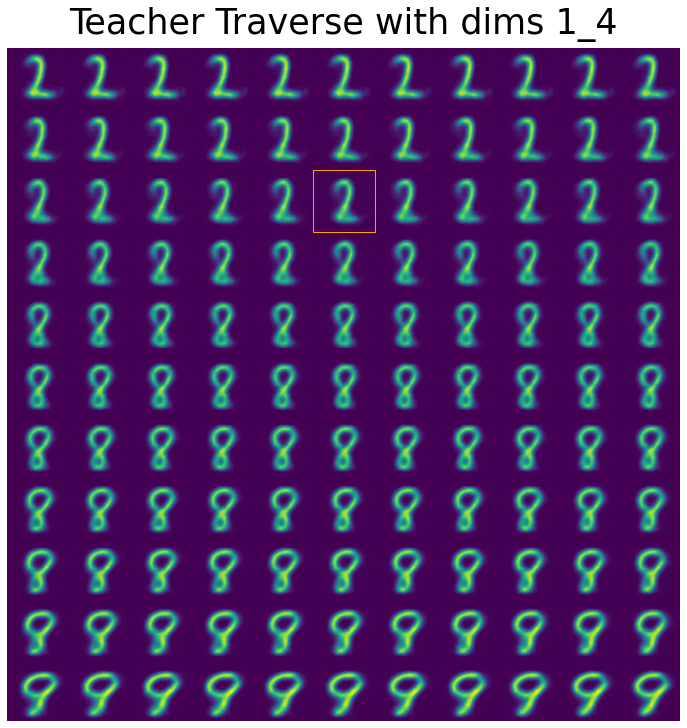

In [66]:
%matplotlib inline
trainer.traverse_latent(180, data_train, dim1=1, dim2=4)

In [68]:
torch.save(trainer.img_encoder.state_dict(), '../Models/VAE_MNIST_en_300ep_dim8.pth')
torch.save(trainer.img_decoder.state_dict(), '../Models/VAE_MNIST_de_300ep_dim8.pth')